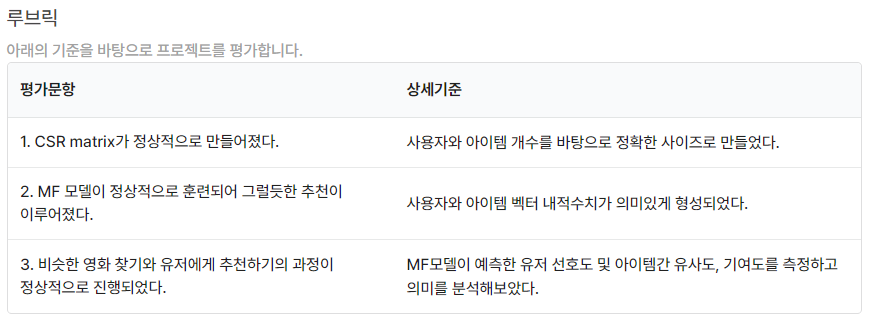

# 13-9. 프로젝트 - Movielens 영화 추천 실습


이전 스텝에서 배운 MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보겠습니다.

이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터입니다.

- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.


Cloud Storage에 미리 업로드된 ml-1m폴더 내 파일을 심볼릭 링크로 개인 storage에 연결해 줍니다.

Cloud shell에서 아래 명령어를 입력해 주세요.


```bash
$ mkdir -p ~/aiffel/recommendata_iu/data/ml-1m
$ ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m
```


프로젝트에 필요한 주요 라이브러리 버전을 확인해봅시다.

In [1]:
import numpy as np
import scipy
import implicit

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.19.5
1.7.1
0.4.8


In [2]:
import pandas as pd

### 1) 데이터 준비와 전처리
----
Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.


```python
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()
```

In [3]:
import os
rating_file_path = './data/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
rating_file_path = './data/ratings.dat'
ratings_data = pd.read_csv(rating_file_path, sep='::', engine='python', encoding = "ISO-8859-1")
ratings_data.head()

,1,1193,5,978300760
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,2355,5,978824291
4,1,1197,3,978302268


In [5]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [6]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [7]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

#### 필요없는 데이터인 timestamp  columns를 삭제한다. 

In [8]:
ratings.drop(['timestamp'], axis=1, inplace=True)

ratings.head()

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   836478 non-null  int64
 1   movie_id  836478 non-null  int64
 2   counts    836478 non-null  int64
dtypes: int64(3)
memory usage: 25.5 MB


In [10]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path='./data/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


- title과 genre를 소문자로 바꿔준다. 

In [11]:
movies['title'] = movies['title'].str.lower()
movies['genre'] = movies['genre'].str.lower()
movies.head(10)

,movie_id,title,genre
0,1,toy story (1995),animation|children's|comedy
1,2,jumanji (1995),adventure|children's|fantasy
2,3,grumpier old men (1995),comedy|romance
3,4,waiting to exhale (1995),comedy|drama
4,5,father of the bride part ii (1995),comedy
5,6,heat (1995),action|crime|thriller
6,7,sabrina (1995),comedy|romance
7,8,tom and huck (1995),adventure|children's
8,9,sudden death (1995),action
9,10,goldeneye (1995),action|adventure|thriller


In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [13]:
movies.loc[movies['movie_id'] == 733]

,movie_id,title,genre
724,733,"rock, the (1996)",action|adventure|thriller


In [14]:
movies['title'].loc[movies['movie_id'] == 733]

724    rock, the (1996)
Name: title, dtype: object

여기까지가 전처리입니다. 이후에는 이전 스텝에 소개했던 것과 동일한 방식으로 MF model을 구성하여 내가 좋아할 만한 영화를 추천해 볼 수 있습니다.

### 2) 분석해 봅시다.
----
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

- 유저수와 rating에 있는 영화 개수

In [15]:
ratings['user_id'].nunique()

6039

In [16]:
ratings['movie_id'].nunique()

3628

- 가장 인기있는 영화 30개를 뽑기 위해 가장 먼저 두 DataFrame을 합친다. 

In [17]:
ratings_title = pd.merge(ratings, movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id')

ratings_title

,user_id,movie_id,counts,title,genre
0,1,1193,5,one flew over the cuckoo's nest (1975),drama
1,1,661,3,james and the giant peach (1996),animation|children's|musical
2,1,914,3,my fair lady (1964),musical|romance
3,1,3408,4,erin brockovich (2000),drama
4,1,2355,5,"bug's life, a (1998)",animation|children's|comedy
...,...,...,...,...,...
836473,6040,1090,3,platoon (1986),drama|war
836474,6040,1094,5,"crying game, the (1992)",drama|romance|war
836475,6040,562,5,welcome to the dollhouse (1995),comedy|drama
836476,6040,1096,4,sophie's choice (1982),drama


### 가장인기있는 영화 30선
- 기준에 따라 영화 리스트가 다를 것이다. 
- 첫번째 기준은 전체 평균 평점기준
    - 유저마다 메긴 평점의 평균값이 높은 순으로 정렬한다. 
    - 이 경우 현재 데이터가 2점 이하는 제거 되었으므로 약간의 왜곡이 있을 수 있다. 


In [18]:
favorite_movie = ratings_title.groupby('title')['counts'].mean()
favorite_movie.sort_values(ascending=False).head(30)

title
gate of heavenly peace, the (1995)                                     5.000000
follow the bitch (1998)                                                5.000000
identification of a woman (identificazione di una donna) (1982)        5.000000
schlafes bruder (brother of sleep) (1995)                              5.000000
criminal lovers (les amants criminels) (1999)                          5.000000
country life (1994)                                                    5.000000
foreign student (1994)                                                 5.000000
lured (1947)                                                           5.000000
baby, the (1973)                                                       5.000000
late bloomers (1996)                                                   5.000000
zachariah (1971)                                                       5.000000
bittersweet motel (2000)                                               5.000000
black sunday (la maschera del demo

- 두번째 기준은 유저들이 메긴 별정의 총합을 따진다. 
    - 이 경우 많은 사람이 보고 평가한 영화의 순서를 얻을 수 있지만
    - 모든 관람객에게 고르게 높은 점수를 받았는지는 알수 없다. 
    - '가장 인기있는 영화'를 많은 사람이 봤다면 이 리스트가 더 정답에 가까울 것으로 생각한다. 

In [19]:
favorite_movie = ratings_title.groupby('title')['counts'].count()
favorite_movie.sort_values(ascending=False).head(30)

title
american beauty (1999)                                   3211
star wars: episode iv - a new hope (1977)                2910
star wars: episode v - the empire strikes back (1980)    2885
star wars: episode vi - return of the jedi (1983)        2716
saving private ryan (1998)                               2561
terminator 2: judgment day (1991)                        2509
silence of the lambs, the (1991)                         2498
raiders of the lost ark (1981)                           2473
back to the future (1985)                                2460
matrix, the (1999)                                       2434
jurassic park (1993)                                     2413
sixth sense, the (1999)                                  2385
fargo (1996)                                             2371
braveheart (1995)                                        2314
men in black (1997)                                      2297
schindler's list (1993)                                  2257
pr

### 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.
----

In [20]:
ratings['user_id'].unique()

array([   1,    2,    3, ..., 6038, 6039, 6040], dtype=int64)

#### 선호하기 위한 영화를 추가하기 앞서서 내 가 좋아하는 영화의 movie_id를 확인한다. 
- str.contain() 메소드를 사용한다. 

In [21]:
print(movies[movies['title'].str.contains('star wars')])

      movie_id                                              title  \
257        260          star wars: episode iv - a new hope (1977)   
1178      1196  star wars: episode v - the empire strikes back...   
1192      1210  star wars: episode vi - return of the jedi (1983)   
2559      2628   star wars: episode i - the phantom menace (1999)   

                                    genre  
257       action|adventure|fantasy|sci-fi  
1178    action|adventure|drama|sci-fi|war  
1192  action|adventure|romance|sci-fi|war  
2559      action|adventure|fantasy|sci-fi  


- 아마 2000년도까지의 영화만 있는 듯 하다. 검색하기 쉽지 않다
- the rock 733
- star wars episode 1 2559
- star wars episode 6 1210
- peacemaker 1616

In [22]:
print(movies[movies['title'].str.contains('peacemaker')])

      movie_id                   title                genre
1574      1616  peacemaker, the (1997)  action|thriller|war


In [23]:
print(movies[movies['title'].str.contains('speed')])

      movie_id                           title                    genre
373        377                    speed (1994)  action|romance|thriller
1517      1556  speed 2: cruise control (1997)  action|romance|thriller
1675      1724               full speed (1996)                    drama


In [24]:
print(movies[movies['title'].str.contains('indiana')])

      movie_id                                        title             genre
1271      1291    indiana jones and the last crusade (1989)  action|adventure
2046      2115  indiana jones and the temple of doom (1984)  action|adventure


#### ratings dataframe에 6041이라는 id로 영화를 추가한다. 

In [25]:
ratings.head()

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [26]:
my_movies = [755, 2559, 1210, 1616, 377, 1291, 2115]

len(my_movies)

7

In [27]:
my_favorite = pd.DataFrame({'user_id': [6041] * len(my_movies), 'movie_id': my_movies, 'counts': [5] * len(my_movies)})

my_favorite

,user_id,movie_id,counts
0,6041,755,5
1,6041,2559,5
2,6041,1210,5
3,6041,1616,5
4,6041,377,5
5,6041,1291,5
6,6041,2115,5


In [28]:
# if not ratings.isin({'user_id': [6041]})['user_id'].any():
#     ratings = ratings.append(my_favorite)
    
# ratings.tail(10)

### 4) CSR matrix를 직접 만들어 봅시다.
----

In [29]:
using_cols = ['user_id','movie_id','counts']
data = ratings[using_cols]

In [30]:
my_favorite = [2028,1196,2571,858,1,2273]
my_playlist = pd.DataFrame({'user_id': ['zimin']*6, 'movie_id': my_favorite, 'counts':[5]*6})
my_playlist

,user_id,movie_id,counts
0,zimin,2028,5
1,zimin,1196,5
2,zimin,2571,5
3,zimin,858,5
4,zimin,1,5
5,zimin,2273,5


In [31]:
if not data.isin({'user_id':['zimin']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)

,user_id,movie_id,counts
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4
1000208,6040,1097,4
0,zimin,2028,5
1,zimin,1196,5
2,zimin,2571,5
3,zimin,858,5
4,zimin,1,5
5,zimin,2273,5


In [37]:
data = pd.merge(data, movies, left_on = 'movie_id',right_on = 'movie_id', how='left')

In [38]:
data

,user_id,movie_id,counts,title,genre
0,1,1193,5,one flew over the cuckoo's nest (1975),drama
1,1,661,3,james and the giant peach (1996),animation|children's|musical
2,1,914,3,my fair lady (1964),musical|romance
3,1,3408,4,erin brockovich (2000),drama
4,1,2355,5,"bug's life, a (1998)",animation|children's|comedy
...,...,...,...,...,...
836479,zimin,1196,5,star wars: episode v - the empire strikes back...,action|adventure|drama|sci-fi|war
836480,zimin,2571,5,"matrix, the (1999)",action|sci-fi|thriller
836481,zimin,858,5,"godfather, the (1972)",action|crime|drama
836482,zimin,1,5,toy story (1995),animation|children's|comedy


In [39]:
len(data['movie_id'].unique())

3628

In [40]:
len(data['title'].unique()) # 중복된 타이틀이 있을 수 있어 위 unique 숫자와 일치

3628

In [41]:
my_movies = list(data.loc[data['movie_id'].isin(my_favorite)].title.unique())
my_movies

['toy story (1995)',
 'saving private ryan (1998)',
 'star wars: episode v - the empire strikes back (1980)',
 'matrix, the (1999)',
 'godfather, the (1972)',
 'rush hour (1998)']

In [42]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
movie_unique = data['title'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [47]:
user_to_idx

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

In [51]:
movie_to_idx

{"one flew over the cuckoo's nest (1975)": 0,
 'james and the giant peach (1996)': 1,
 'my fair lady (1964)': 2,
 'erin brockovich (2000)': 3,
 "bug's life, a (1998)": 4,
 'princess bride, the (1987)': 5,
 'ben-hur (1959)': 6,
 'christmas story, a (1983)': 7,
 'snow white and the seven dwarfs (1937)': 8,
 'wizard of oz, the (1939)': 9,
 'beauty and the beast (1991)': 10,
 'gigi (1958)': 11,
 'miracle on 34th street (1947)': 12,
 "ferris bueller's day off (1986)": 13,
 'sound of music, the (1965)': 14,
 'airplane! (1980)': 15,
 'tarzan (1999)': 16,
 'bambi (1942)': 17,
 'awakenings (1990)': 18,
 'big (1988)': 19,
 'pleasantville (1998)': 20,
 'wallace & gromit: the best of aardman animation (1996)': 21,
 'back to the future (1985)': 22,
 "schindler's list (1993)": 23,
 'meet joe black (1998)': 24,
 'pocahontas (1995)': 25,
 'e.t. the extra-terrestrial (1982)': 26,
 'titanic (1997)': 27,
 'ponette (1996)': 28,
 'close shave, a (1995)': 29,
 'antz (1998)': 30,
 'girl, interrupted (1999)':

In [43]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['zimin'])    # 6040명의 유저 중 마지막으로 추가된 유저이니 6039이 나와야 합니다. 
print(movie_to_idx['toy story (1995)'])

6039
40


In [45]:

# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
temp_user_data

0            0
1            0
2            0
3            0
4            0
          ... 
836479    6039
836480    6039
836481    6039
836482    6039
836483    6039
Name: user_id, Length: 836484, dtype: int64

In [46]:
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

user_id column indexing OK!!


In [48]:
# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = data['title'].map(movie_to_idx.get).dropna()

In [49]:
if len(temp_movie_data) == len(data):
    print('movie column indexing OK!!')
    data['movie_id'] = temp_movie_data
else:
    print('movie column indexing Fail!!')

movie column indexing OK!!


In [50]:
data

,user_id,movie_id,counts,title,genre
0,0,0,5,one flew over the cuckoo's nest (1975),drama
1,0,1,3,james and the giant peach (1996),animation|children's|musical
2,0,2,3,my fair lady (1964),musical|romance
3,0,3,4,erin brockovich (2000),drama
4,0,4,5,"bug's life, a (1998)",animation|children's|comedy
...,...,...,...,...,...
836479,6039,117,5,star wars: episode v - the empire strikes back...,action|adventure|drama|sci-fi|war
836480,6039,124,5,"matrix, the (1999)",action|sci-fi|thriller
836481,6039,607,5,"godfather, the (1972)",action|crime|drama
836482,6039,40,5,toy story (1995),animation|children's|comedy


In [53]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_movie = data['title'].nunique()

csr_data = csr_matrix((data.counts, (data.user_id, data.movie_id)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836484 stored elements in Compressed Sparse Row format>

In [32]:
#[[ your code ]]

### 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.
-----

In [33]:
#[[ your code ]]

### 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [34]:
#[[ your code ]]

7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [35]:
#[[ your code ]]

8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

In [36]:
#[[ your code ]]